#Proyecto de Procesamiento de Alto Volumen de Datos  
## **Análisis de Seguridad, Pobreza y Educación en la Ciudad de Nueva York**

**Pontificia Universidad Javeriana – Facultad de Ingeniería**  
**Departamento de Ingeniería de Sistemas**  
**Asignatura:** Procesamiento de Alto Volumen de Datos  
**Docente:** John Corredor Franco, PhD  
**Periodo:** 2025-2  

---

### **Contexto del proyecto**

Este proyecto se desarrolla bajo la metodología **CRISP-DM (Cross Industry Standard Process for Data Mining)**, la cual guía el proceso de análisis de datos en seis fases:  
1. Entendimiento del negocio  
2. Entendimiento de los datos  
3. Preparación de los datos  
4. Modelado  
5. Evaluación  
6. Despliegue  

La presente entrega aborda las dos primeras fases, centradas en el **entendimiento del negocio y de los datos**, mediante la integración de información pública proveniente del portal [NYC Open Data](https://data.cityofnewyork.us/).  

El objetivo principal es **analizar la relación entre las condiciones socioeconómicas, educativas y los indicadores de seguridad (arrestos y accidentes viales)**, empleando **Apache Spark** como herramienta de procesamiento distribuido.

---

### **Objetivo del notebook**

Este notebook tiene como propósito documentar paso a paso el proceso de **configuración del entorno Spark**, **carga de los datasets seleccionados**, y la **descripción técnica inicial de los datos** utilizados en el proyecto:

- **NYPD Arrest Data (Year-to-Date)**  
  [https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc](https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc)

- **Motor Vehicle Collisions – Vehicles**  
  [https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Vehicles/bm4k-52h4](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Vehicles/bm4k-52h4)

- **NYCgov Poverty Measure Data**  
  [https://data.cityofnewyork.us/City-Government/NYCgov-Poverty-Measure-Data/ct7s-vksw](https://data.cityofnewyork.us/City-Government/NYCgov-Poverty-Measure-Data/ct7s-vksw)

- **SAT Results (NYC Department of Education)**  
  [https://data.cityofnewyork.us/Education/2012-SAT-Results/zt9s-n5aj](https://data.cityofnewyork.us/Education/2012-SAT-Results/zt9s-n5aj)

---

### **Estructura del notebook**

1. **Configuración del entorno Spark**  
   - Creación de la sesión Spark.  
   - Verificación de instalación y recursos del cluster.  

2. **Carga de datasets en formato distribuido**  
   - Lectura de archivos CSV desde el entorno local o HDFS.  
   - Inspección de las primeras filas de cada dataset.  

3. **Descripción técnica y validación**  
   - Estructura de los datos (`printSchema()`).  
   - Conteo de registros y revisión general de atributos.  

4. **Exploración preliminar (EDA inicial)**  
   - Estadísticas descriptivas (`describe()`).  
   - Conteo de valores nulos y duplicados.  

5. **Conclusiones parciales**  
   - Observaciones sobre la calidad y completitud de los datos.  
   - Propuesta de próximos pasos (limpieza, integración y modelado).  

---

### **Equipo consultor**

- *Natalia Echeverry Salcedo*  
- *Sergio Felipe Barreto Cifuentes* 
- *Juan Diego Bernal Piñeros*  

---


In [1]:
# Módulos del sistema para manejo de rutas y paquetes.
import os
import sys
sys.path.append('/usr/lib/python3/dist-packages/')

# Librerías para análisis y visualización de datos.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *

# Inicialización del entorno Spark.
import findspark
findspark.init()

# Funciones y estructuras principales de PySpark.
import pyspark.sql.functions as F
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *

In [2]:
# Se define la configuración básica de la aplicación en Spark.
configura = SparkConf()
configura.setAppName("Proyecto_NY_BigData")  # Nombre asignado a la sesión de Spark.

# Creación de la sesión principal de Spark.
# SparkSession es el punto de entrada para trabajar con DataFrames distribuidos.
spark03 = SparkSession.builder.config(conf=configura).getOrCreate()

# Inicializa el contexto SQL asociado a la sesión.
SQLContext(sparkContext=spark03.sparkContext, sparkSession=spark03)

# Obtiene o crea el contexto principal de Spark.
sparkContexto03 = spark03.sparkContext.getOrCreate()

# Confirmación en consola de la sesión activa.
print("Sesión creada: HPC004")
spark03  # Muestra información de la sesión activa.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/16 18:43:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/16 18:43:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/11/16 18:43:58 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Sesión creada: HPC004


**Carga de los datasets del proyecto**

In [3]:
import pandas as pd

# Arrestos del NYPD
arrestos_pd = pd.read_excel("NYPD_Arrest_Data_(Year_to_Date)_20251020.xlsx")
arrestos_df = spark03.createDataFrame(arrestos_pd)

In [4]:
# Colisiones vehiculares
colisiones_pd = pd.read_excel(
    "Motor_Vehicle_Collisions_-_Vehicles_20251020.xlsx",
    nrows=10000  # Solo las primeras 10k filas
)
colisiones_df = spark03.createDataFrame(colisiones_pd)

In [5]:
# Medición de pobreza
pobreza_pd = pd.read_excel("NYCgov_Poverty_Measure_Data_(2018)_20251020.xlsx")
pobreza_df = spark03.createDataFrame(pobreza_pd)

In [6]:
# Resultados SAT (educación)
sat_pd = pd.read_excel("SAT_Results.xlsx")
sat_df = spark03.createDataFrame(sat_pd)

In [7]:
# Verificación de carga
print("Registros en arrestos:", arrestos_df.count())
print("Registros en colisiones:", colisiones_df.count())
print("Registros en pobreza:", pobreza_df.count())
print("Registros en SAT:", sat_df.count())

Registros en arrestos: 143494


25/11/16 18:48:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Registros en colisiones: 10000
Registros en pobreza: 68273
Registros en SAT: 16


In [8]:
sat_df.show(5)
arrestos_df.show(5)
colisiones_df.show(5)
pobreza_df.show(5)

+--------------------+--------------------+
|          Unnamed: 0|          Unnamed: 1|
+--------------------+--------------------+
|Data Dictionary -...|                 NaN|
|                 NaN|                 NaN|
|             General|                 NaN|
|        Dataset Name|         SAT Results|
|         Agency Name|New York City Dep...|
+--------------------+--------------------+
only showing top 5 rows

+----------+-------------------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+----------------+-----------------+------------------------+
|ARREST_KEY|        ARREST_DATE|PD_CD|             PD_DESC|KY_CD|           OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|     PERP_RACE|X_COORD_CD|Y_COORD_CD|        Latitude|        Longitude|New Georeferenced Column|
+----------+-------------------+-----

**Carga del dataset real del SAT (resultados 2012)**

In [9]:
# El dataset real contiene los puntajes promedio de lectura, matemáticas y escritura por escuela.
# Fuente oficial: NYC Department of Education (2012)
# https://data.cityofnewyork.us/Education/SAT-College-Board-2010-School-Level-Results/zt9s-n5aj/about_data

# Leer el archivo Excel real con pandas
sat_real_pd = pd.read_excel("SAT_(College_Board)_2010_School_Level_Results_20251020.xlsx")  

# Convertirlo a DataFrame de Spark
sat_real_df = spark03.createDataFrame(sat_real_pd)

print("Registros en SAT real:", sat_real_df.count())
print("Columnas en SAT real:", len(sat_real_df.columns))
print("\n=== Columnas del dataset SAT real ===")
print(sat_real_df.columns)

sat_real_df.show(5)

Registros en SAT real: 460
Columnas en SAT real: 6

=== Columnas del dataset SAT real ===
['DBN', 'School Name', 'Number of Test Takers', 'Critical Reading Mean', 'Mathematics Mean', 'Writing Mean']
+------+--------------------+---------------------+---------------------+----------------+------------+
|   DBN|         School Name|Number of Test Takers|Critical Reading Mean|Mathematics Mean|Writing Mean|
+------+--------------------+---------------------+---------------------+----------------+------------+
|01M292|Henry Street Scho...|                 31.0|                391.0|           425.0|       385.0|
|01M448|University Neighb...|                 60.0|                394.0|           419.0|       387.0|
|01M450|East Side Communi...|                 69.0|                418.0|           431.0|       402.0|
|01M458|SATELLITE ACADEMY...|                 26.0|                385.0|           370.0|       378.0|
|01M509|   CMSP HIGH SCHOOL |                  NaN|                  NaN|

**Descripción técnica de los datasets**

In [10]:
print("=== Estructura de Arrestos ===")
arrestos_df.printSchema()
arrestos_df.show(5)

print("=== Estructura de Colisiones ===")
colisiones_df.printSchema()
colisiones_df.show(5)

print("=== Estructura de Pobreza ===")
pobreza_df.printSchema()
pobreza_df.show(5)

print("=== Estructura de SAT (Educación) ===")
sat_df.printSchema()
sat_df.show(5)

print("=== Estructura de SAT 2012 (Educación) ===")
sat_real_df.printSchema()
sat_real_df.show(5)

=== Estructura de Arrestos ===
root
 |-- ARREST_KEY: long (nullable = true)
 |-- ARREST_DATE: timestamp (nullable = true)
 |-- PD_CD: long (nullable = true)
 |-- PD_DESC: string (nullable = true)
 |-- KY_CD: double (nullable = true)
 |-- OFNS_DESC: string (nullable = true)
 |-- LAW_CODE: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)
 |-- ARREST_BORO: string (nullable = true)
 |-- ARREST_PRECINCT: long (nullable = true)
 |-- JURISDICTION_CODE: long (nullable = true)
 |-- AGE_GROUP: string (nullable = true)
 |-- PERP_SEX: string (nullable = true)
 |-- PERP_RACE: string (nullable = true)
 |-- X_COORD_CD: long (nullable = true)
 |-- Y_COORD_CD: long (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- New Georeferenced Column: string (nullable = true)

+----------+-------------------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+-----

**Análisis descriptivo inicial**

In [11]:
# Número de columnas por dataset
print("Columnas en Arrestos:", len(arrestos_df.columns))
print("Columnas en Colisiones:", len(colisiones_df.columns))
print("Columnas en Pobreza:", len(pobreza_df.columns))
print("Columnas en SAT:", len(sat_df.columns))

# Nombres de columnas (útil para revisión)
print("\n=== Columnas de Arrestos ===")
print(arrestos_df.columns)

print("\n=== Columnas de Colisiones ===")
print(colisiones_df.columns)

print("\n=== Columnas de Pobreza ===")
print(pobreza_df.columns)

print("\n=== Columnas de SAT ===")
print(sat_df.columns)

print("\n=== Columnas de SAT 2012 ===")
print(sat_real_df.columns)


# Conteo de valores nulos (por columna)
from pyspark.sql.functions import col, sum

def contar_nulos(df):
    return df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

print("\n=== Valores nulos en Arrestos ===")
contar_nulos(arrestos_df).show()

print("\n=== Valores nulos en Colisiones ===")
contar_nulos(colisiones_df).show()

print("\n=== Valores nulos en Pobreza ===")
contar_nulos(pobreza_df).show()

print("\n=== Valores nulos en SAT ===")
contar_nulos(sat_df).show()

print("\n=== Valores nulos en SAT 2012 ===")
contar_nulos(sat_real_df).show()


Columnas en Arrestos: 19
Columnas en Colisiones: 25
Columnas en Pobreza: 61
Columnas en SAT: 2

=== Columnas de Arrestos ===
['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'New Georeferenced Column']

=== Columnas de Colisiones ===
['UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'VEHICLE_ID', 'STATE_REGISTRATION', 'VEHICLE_TYPE', 'VEHICLE_MAKE', 'VEHICLE_MODEL', 'VEHICLE_YEAR', 'TRAVEL_DIRECTION', 'VEHICLE_OCCUPANTS', 'DRIVER_SEX', 'DRIVER_LICENSE_STATUS', 'DRIVER_LICENSE_JURISDICTION', 'PRE_CRASH', 'POINT_OF_IMPACT', 'VEHICLE_DAMAGE', 'VEHICLE_DAMAGE_1', 'VEHICLE_DAMAGE_2', 'VEHICLE_DAMAGE_3', 'PUBLIC_PROPERTY_DAMAGE', 'PUBLIC_PROPERTY_DAMAGE_TYPE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2']

=== Columnas de Pobreza ===
['SERIALNO', 'SPORDER', 'PWGTP', 'WGTP', 'AGEP', 'CIT',

**Análisis exploratorio del dataset SAT (Educación)**

In [12]:
# Mostrar estructura y columnas del dataset SAT
print("=== Columnas del dataset SAT ===")
print(sat_real_df.columns)

# Mostrar las primeras filas (para revisar qué variables numéricas tiene)
print("\n=== Vista previa del dataset SAT ===")
sat_real_df.show(10)

=== Columnas del dataset SAT ===
['DBN', 'School Name', 'Number of Test Takers', 'Critical Reading Mean', 'Mathematics Mean', 'Writing Mean']

=== Vista previa del dataset SAT ===
+------+--------------------+---------------------+---------------------+----------------+------------+
|   DBN|         School Name|Number of Test Takers|Critical Reading Mean|Mathematics Mean|Writing Mean|
+------+--------------------+---------------------+---------------------+----------------+------------+
|01M292|Henry Street Scho...|                 31.0|                391.0|           425.0|       385.0|
|01M448|University Neighb...|                 60.0|                394.0|           419.0|       387.0|
|01M450|East Side Communi...|                 69.0|                418.0|           431.0|       402.0|
|01M458|SATELLITE ACADEMY...|                 26.0|                385.0|           370.0|       378.0|
|01M509|   CMSP HIGH SCHOOL |                  NaN|                  NaN|             NaN|  

**Promedios generales del SAT (Lectura, Matemáticas, Escritura)**

In [13]:
# Verificar tipos de datos de cada columna
print("=== Tipos de datos en el dataset SAT real ===")
sat_real_df.printSchema()


=== Tipos de datos en el dataset SAT real ===
root
 |-- DBN: string (nullable = true)
 |-- School Name: string (nullable = true)
 |-- Number of Test Takers: double (nullable = true)
 |-- Critical Reading Mean: double (nullable = true)
 |-- Mathematics Mean: double (nullable = true)
 |-- Writing Mean: double (nullable = true)



In [14]:
from pyspark.sql.functions import col

# Convertir columnas a tipo numérico
sat_real_df = sat_real_df.withColumn("Critical Reading Mean", col("Critical Reading Mean").cast("float")) \
                         .withColumn("Mathematics Mean", col("Mathematics Mean").cast("float")) \
                         .withColumn("Writing Mean", col("Writing Mean").cast("float"))


In [15]:
# Limpiar filas con valores nulos en las columnas numéricas
sat_real_df_limpio = sat_real_df.na.drop(subset=["Critical Reading Mean", "Mathematics Mean", "Writing Mean"])

# Confirmar número de filas antes y después de limpiar
print("Filas antes:", sat_real_df.count())
print("Filas después de limpiar:", sat_real_df_limpio.count())


Filas antes: 460
Filas después de limpiar: 386


In [16]:
filas_totales = sat_real_df.count()
filas_validas = sat_real_df.na.drop(subset=["Critical Reading Mean", "Mathematics Mean", "Writing Mean"]).count()

print(f"Total: {filas_totales} | Sin nulos: {filas_validas} | Pérdidas: {filas_totales - filas_validas}")

Total: 460 | Sin nulos: 386 | Pérdidas: 74


In [17]:
from pyspark.sql.functions import avg, round

promedios_sat = sat_real_df_limpio.select(
    round(avg(col("Critical Reading Mean")), 2).alias("Promedio Lectura"),
    round(avg(col("Mathematics Mean")), 2).alias("Promedio Matemáticas"),
    round(avg(col("Writing Mean")), 2).alias("Promedio Escritura")
)

print("=== Promedios generales del SAT 2012 ===")
promedios_sat.show()

=== Promedios generales del SAT 2012 ===
+----------------+--------------------+------------------+
|Promedio Lectura|Promedio Matemáticas|Promedio Escritura|
+----------------+--------------------+------------------+
|          404.25|              412.94|            397.69|
+----------------+--------------------+------------------+



In [18]:
# ===============================================================
# 4. Selección de datos a utilizar
# ===============================================================

from pyspark.sql import DataFrame

# Diccionario con los datasets seleccionados
datasets_info = {
    "NYPD Arrest Data (Year-to-Date)": "NYPD_Arrest_Data_(Year_to_Date)_20251020.xlsx",
    "Motor Vehicle Collisions – Vehicles": "Motor_Vehicle_Collisions_-_Vehicles_20251020.xlsx",
    "NYCgov Poverty Measure Data": "NYCgov_Poverty_Measure_Data_(2018)_20251020.xlsx",
    "SAT Results (Education)": "SAT_Results.xlsx"
}

# Cargar los archivos seleccionados como DataFrames de PySpark
arrestos_df = spark03.createDataFrame(pd.read_excel(datasets_info["NYPD Arrest Data (Year-to-Date)"]))
colisiones_df = spark03.createDataFrame(pd.read_excel(datasets_info["Motor Vehicle Collisions – Vehicles"],nrows=10000))
pobreza_df = spark03.createDataFrame(pd.read_excel(datasets_info["NYCgov Poverty Measure Data"]))
sat_df = spark03.createDataFrame(pd.read_excel(datasets_info["SAT Results (Education)"]))

# Verificar estructura general de los datasets seleccionados
print("=== Selección final de datasets a utilizar ===\n")
for nombre, df in {
    "Arrestos": arrestos_df,
    "Colisiones": colisiones_df,
    "Pobreza": pobreza_df,
    "SAT (Educación)": sat_df
}.items():
    print(f"{nombre}: {df.count()} registros, {len(df.columns)} columnas")
    df.printSchema()
    print("---------------------------------------------")



=== Selección final de datasets a utilizar ===



Arrestos: 143494 registros, 19 columnas
root
 |-- ARREST_KEY: long (nullable = true)
 |-- ARREST_DATE: timestamp (nullable = true)
 |-- PD_CD: long (nullable = true)
 |-- PD_DESC: string (nullable = true)
 |-- KY_CD: double (nullable = true)
 |-- OFNS_DESC: string (nullable = true)
 |-- LAW_CODE: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)
 |-- ARREST_BORO: string (nullable = true)
 |-- ARREST_PRECINCT: long (nullable = true)
 |-- JURISDICTION_CODE: long (nullable = true)
 |-- AGE_GROUP: string (nullable = true)
 |-- PERP_SEX: string (nullable = true)
 |-- PERP_RACE: string (nullable = true)
 |-- X_COORD_CD: long (nullable = true)
 |-- Y_COORD_CD: long (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- New Georeferenced Column: string (nullable = true)

---------------------------------------------
Colisiones: 10000 registros, 25 columnas
root
 |-- UNIQUE_ID: long (nullable = true)
 |-- COLLISION_ID: long (null

**Exploración de los Datos**

In [19]:
# Exploración de los datasets
for nombre, df in {
    "Arrestos": arrestos_df,
    "Colisiones": colisiones_df,
    "Pobreza": pobreza_df,
    "SAT (Educación)": sat_real_df
}.items():
    print(f"\n=== Estructura del dataset {nombre} ===")
    df.printSchema()
    print("\nColumnas:", df.columns)
    print("\nVista previa:")
    df.show(5)
    
    print("\n=== Valores nulos en", nombre, "===")
    df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()


=== Estructura del dataset Arrestos ===
root
 |-- ARREST_KEY: long (nullable = true)
 |-- ARREST_DATE: timestamp (nullable = true)
 |-- PD_CD: long (nullable = true)
 |-- PD_DESC: string (nullable = true)
 |-- KY_CD: double (nullable = true)
 |-- OFNS_DESC: string (nullable = true)
 |-- LAW_CODE: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)
 |-- ARREST_BORO: string (nullable = true)
 |-- ARREST_PRECINCT: long (nullable = true)
 |-- JURISDICTION_CODE: long (nullable = true)
 |-- AGE_GROUP: string (nullable = true)
 |-- PERP_SEX: string (nullable = true)
 |-- PERP_RACE: string (nullable = true)
 |-- X_COORD_CD: long (nullable = true)
 |-- Y_COORD_CD: long (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- New Georeferenced Column: string (nullable = true)


Columnas: ['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CO

+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|PD_DESC|KY_CD|OFNS_DESC|LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|New Georeferenced Column|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|         0|          0|    0|      0|    0|        0|       0|         0|          0|              0|                0|        0|       0|        0|         0|         0|       0|        0|                       0|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+------

+---------+------------+----------+----------+----------+------------------+------------+------------+-------------+------------+----------------+-----------------+----------+---------------------+---------------------------+---------+---------------+--------------+----------------+----------------+----------------+----------------------+---------------------------+---------------------+---------------------+
|UNIQUE_ID|COLLISION_ID|CRASH_DATE|CRASH_TIME|VEHICLE_ID|STATE_REGISTRATION|VEHICLE_TYPE|VEHICLE_MAKE|VEHICLE_MODEL|VEHICLE_YEAR|TRAVEL_DIRECTION|VEHICLE_OCCUPANTS|DRIVER_SEX|DRIVER_LICENSE_STATUS|DRIVER_LICENSE_JURISDICTION|PRE_CRASH|POINT_OF_IMPACT|VEHICLE_DAMAGE|VEHICLE_DAMAGE_1|VEHICLE_DAMAGE_2|VEHICLE_DAMAGE_3|PUBLIC_PROPERTY_DAMAGE|PUBLIC_PROPERTY_DAMAGE_TYPE|CONTRIBUTING_FACTOR_1|CONTRIBUTING_FACTOR_2|
+---------+------------+----------+----------+----------+------------------+------------+------------+-------------+------------+----------------+-----------------+----------

+--------+-------+-----+----+----+---+---+---+----+----+---+---+----+---+---+---+---+----+---+----+---+---+---+--------+----+-------------+----------+-------------+-------------+--------+-----------+--------+-----------+-------------+--------+-------------+----------+---------------+---------+----------+--------+--------+--------+-------------+---------------+----------+----------------+------------+-------------+------+------+----------+-----------+---------------+--------+--------+--------+--------+-------+---------------+--------+
|SERIALNO|SPORDER|PWGTP|WGTP|AGEP|CIT|REL|SCH|SCHG|SCHL|SEX|ESR|LANX|ENG|MSP|MAR|WKW|WKHP|DIS|JWTR| NP|TEN|HHT|AgeCateg|Boro|CitizenStatus|EducAttain|EST_Childcare|EST_Commuting|EST_EITC|EST_FICAtax|EST_HEAP|EST_Housing|EST_IncomeTax|EST_MOOP|EST_Nutrition|EST_PovGap|EST_PovGapIndex|Ethnicity|FamType_PU|FTPTWork|INTP_adj|MRGP_adj|NYCgov_Income|NYCgov_Pov_Stat|NYCgov_REL|NYCgov_Threshold|Off_Pov_Stat|Off_Threshold|OI_adj|PA_adj|Povunit_ID|Povunit_Rel|PreTax

Se identifican falsos positivos en la identificacion de valores nulos en la tabla SAT

**Reporte de Calidad de Datos**

In [20]:
from pyspark.sql import functions as F

# Revisión de duplicados y valores nulos
for nombre, df in {
    "Arrestos": arrestos_df,
    "Colisiones": colisiones_df,
    "Pobreza": pobreza_df,
    "SAT (Educación)": sat_df
}.items():
    print(f"\n=== Reporte de calidad del dataset {nombre} ===")
    
    # Número total de filas
    total = df.count()
    
    # Duplicados
    duplicados = df.count() - df.dropDuplicates().count()
    
    # Valores nulos
    nulos = df.select([
        F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns
    ])
    
    print(f"Total de filas: {total}")
    print(f"Registros duplicados: {duplicados}")
    print("\nValores nulos por columna:")
    nulos.show()
    print("-" * 60)


=== Reporte de calidad del dataset Arrestos ===


Total de filas: 143494
Registros duplicados: 0

Valores nulos por columna:


+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|PD_DESC|KY_CD|OFNS_DESC|LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|New Georeferenced Column|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|         0|          0|    0|      0|    0|        0|       0|         0|          0|              0|                0|        0|       0|        0|         0|         0|       0|        0|                       0|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+------

Total de filas: 10000
Registros duplicados: 0

Valores nulos por columna:
+---------+------------+----------+----------+----------+------------------+------------+------------+-------------+------------+----------------+-----------------+----------+---------------------+---------------------------+---------+---------------+--------------+----------------+----------------+----------------+----------------------+---------------------------+---------------------+---------------------+
|UNIQUE_ID|COLLISION_ID|CRASH_DATE|CRASH_TIME|VEHICLE_ID|STATE_REGISTRATION|VEHICLE_TYPE|VEHICLE_MAKE|VEHICLE_MODEL|VEHICLE_YEAR|TRAVEL_DIRECTION|VEHICLE_OCCUPANTS|DRIVER_SEX|DRIVER_LICENSE_STATUS|DRIVER_LICENSE_JURISDICTION|PRE_CRASH|POINT_OF_IMPACT|VEHICLE_DAMAGE|VEHICLE_DAMAGE_1|VEHICLE_DAMAGE_2|VEHICLE_DAMAGE_3|PUBLIC_PROPERTY_DAMAGE|PUBLIC_PROPERTY_DAMAGE_TYPE|CONTRIBUTING_FACTOR_1|CONTRIBUTING_FACTOR_2|
+---------+------------+----------+----------+----------+------------------+------------+-----------

Total de filas: 68273
Registros duplicados: 0

Valores nulos por columna:
+--------+-------+-----+----+----+---+---+---+----+----+---+---+----+---+---+---+---+----+---+----+---+---+---+--------+----+-------------+----------+-------------+-------------+--------+-----------+--------+-----------+-------------+--------+-------------+----------+---------------+---------+----------+--------+--------+--------+-------------+---------------+----------+----------------+------------+-------------+------+------+----------+-----------+---------------+--------+--------+--------+--------+-------+---------------+--------+
|SERIALNO|SPORDER|PWGTP|WGTP|AGEP|CIT|REL|SCH|SCHG|SCHL|SEX|ESR|LANX|ENG|MSP|MAR|WKW|WKHP|DIS|JWTR| NP|TEN|HHT|AgeCateg|Boro|CitizenStatus|EducAttain|EST_Childcare|EST_Commuting|EST_EITC|EST_FICAtax|EST_HEAP|EST_Housing|EST_IncomeTax|EST_MOOP|EST_Nutrition|EST_PovGap|EST_PovGapIndex|Ethnicity|FamType_PU|FTPTWork|INTP_adj|MRGP_adj|NYCgov_Income|NYCgov_Pov_Stat|NYCgov_REL|NYCgov_Thresh

**Filtros, Limpieza y Transformaciones Iniciales**

In [21]:
total = arrestos_df.count()
sin_duplicados = arrestos_df.dropDuplicates().count()

print(f"Registros totales: {total}")
print(f"Registros únicos:  {sin_duplicados}")
print(f"Duplicados:        {total - sin_duplicados}")

[Stage 157:==========================================>         (138 + 30) / 168]

Registros totales: 143494
Registros únicos:  143494
Duplicados:        0


In [22]:
total = colisiones_df.count()
sin_duplicados = colisiones_df.dropDuplicates().count()

print(f"Registros totales: {total}")
print(f"Registros únicos:  {sin_duplicados}")
print(f"Duplicados:        {total - sin_duplicados}")

Registros totales: 10000
Registros únicos:  10000
Duplicados:        0


In [23]:
total = pobreza_df.count()
sin_duplicados = pobreza_df.dropDuplicates().count()

print(f"Registros totales: {total}")
print(f"Registros únicos:  {sin_duplicados}")
print(f"Duplicados:        {total - sin_duplicados}")

[Stage 175:======================================>             (124 + 36) / 168]

Registros totales: 68273
Registros únicos:  68273
Duplicados:        0


In [24]:
total = sat_real_df.count()
sin_duplicados = sat_df.dropDuplicates().count()

print(f"Registros totales: {total}")
print(f"Registros únicos:  {sin_duplicados}")
print(f"Duplicados:        {total - sin_duplicados}")

Registros totales: 460
Registros únicos:  13
Duplicados:        447


In [25]:
#Verificar la calidad de los nulos y evitar falsos positivo
from pyspark.sql.functions import when, col, trim, lower

def normalizar_nulos(df):
    for c in df.columns:
        df = df.withColumn(
            c,
            when(
                (trim(lower(col(c))).isin("", "na", "n/a", "null", "none", "NaN")), None
            ).otherwise(col(c))
        )
    return df

arrestos_df = normalizar_nulos(arrestos_df)
pobreza_df = normalizar_nulos(pobreza_df)
colisiones_df = normalizar_nulos(colisiones_df)
sat_real_df = normalizar_nulos(sat_real_df)

In [26]:
from pyspark.sql.functions import col, sum, isnan

def contar_nulos_completo(df):
    return df.select([
        sum((col(c).isNull() | isnan(col(c))).cast("int")).alias(c)
        for c in df.columns
    ])

# Ejemplo con tu dataset SAT
print("=== Conteo de nulos reales SAT===")
contar_nulos_completo(sat_real_df).show(vertical=True)

print("=== Conteo de nulos reales Pobreza===")
contar_nulos_completo(pobreza_df).show(vertical=True)


=== Conteo de nulos reales SAT===
-RECORD 0--------------------
 DBN                   | 0   
 School Name           | 0   
 Number of Test Takers | 74  
 Critical Reading Mean | 74  
 Mathematics Mean      | 74  
 Writing Mean          | 74  

=== Conteo de nulos reales Pobreza===


[Stage 193:==============================>                      (98 + 36) / 168]

-RECORD 0-----------------
 SERIALNO         | 0     
 SPORDER          | 0     
 PWGTP            | 0     
 WGTP             | 0     
 AGEP             | 0     
 CIT              | 0     
 REL              | 0     
 SCH              | 0     
 SCHG             | 0     
 SCHL             | 2107  
 SEX              | 0     
 ESR              | 11798 
 LANX             | 3533  
 ENG              | 37557 
 MSP              | 11021 
 MAR              | 0     
 WKW              | 31394 
 WKHP             | 0     
 DIS              | 0     
 JWTR             | 34956 
 NP               | 0     
 TEN              | 0     
 HHT              | 0     
 AgeCateg         | 0     
 Boro             | 0     
 CitizenStatus    | 0     
 EducAttain       | 2107  
 EST_Childcare    | 0     
 EST_Commuting    | 0     
 EST_EITC         | 0     
 EST_FICAtax      | 0     
 EST_HEAP         | 0     
 EST_Housing      | 0     
 EST_IncomeTax    | 0     
 EST_MOOP         | 0     
 EST_Nutrition    | 0     
 

In [27]:
# Limpiar filas con valores nulos en las columnas numéricas
pobreza_df_limpio = pobreza_df.na.drop(subset=["WKW", "JWTR", "EducAttain"])

# Confirmar número de filas antes y después de limpiar
print("Filas antes:", pobreza_df.count())
print("Filas después de limpiar:", pobreza_df_limpio.count())

Filas antes: 68273
Filas después de limpiar: 33317


Con los valores nulos normalizados se toma la decision de no borrar o llenar la informacion de forma precipitada y en su lugar transformar atributos valiosos para representarlos y sugerir preguntas de negocio

In [28]:
pobreza_df02 = pobreza_df.withColumn("Sexo", F.when((pobreza_df.SEX == 2),'Female')
    .when((pobreza_df.SEX == 1),'Male')
    .otherwise('NI')
                      )

In [29]:
pobreza_df03 = pobreza_df02.withColumn("Matriculado", F.when((pobreza_df02.SCH == 1),'No asistio')
    .when((pobreza_df02.SCH == 2),'Publica')
    .when((pobreza_df02.SCH == 3),'Privada')
    .otherwise('N/A')
                      )

In [30]:
pobreza_df04 = pobreza_df03.withColumn("Estado Civil", F.when((pobreza_df03.MAR == 1),'Casado')
    .when((pobreza_df03.MAR== 2),'Viudo')
    .when((pobreza_df03.MAR== 3),'Divorciado')
    .when((pobreza_df03.MAR== 4),'Separado')
    .otherwise('Nunca se caso')
                      )

In [31]:
pobreza_df05 = pobreza_df04.withColumn("Etnicidad", F.when((pobreza_df04.Ethnicity == 1),'Blanco')
    .when((pobreza_df04.Ethnicity== 2),'Negro')
    .when((pobreza_df04.Ethnicity== 3),'Asiatico')
    .when((pobreza_df04.Ethnicity== 4),'Hispano')
    .otherwise('Otro')
                      )

In [32]:
pobreza_df05.show(5)


+--------+-------+-----+----+----+---+---+---+----+----+---+---+----+---+---+---+---+----+---+----+---+---+---+--------+----+-------------+----------+-------------+-------------+--------+-----------+--------+-----------+-------------+---------+-------------+----------+---------------+---------+----------+--------+---------+---------+-------------+---------------+----------+----------------+------------+-------------+------+------+----------+-----------+---------------+--------+--------+--------+--------+---------+---------------+---------+------+-----------+-------------+---------+
|SERIALNO|SPORDER|PWGTP|WGTP|AGEP|CIT|REL|SCH|SCHG|SCHL|SEX|ESR|LANX|ENG|MSP|MAR|WKW|WKHP|DIS|JWTR| NP|TEN|HHT|AgeCateg|Boro|CitizenStatus|EducAttain|EST_Childcare|EST_Commuting|EST_EITC|EST_FICAtax|EST_HEAP|EST_Housing|EST_IncomeTax| EST_MOOP|EST_Nutrition|EST_PovGap|EST_PovGapIndex|Ethnicity|FamType_PU|FTPTWork| INTP_adj| MRGP_adj|NYCgov_Income|NYCgov_Pov_Stat|NYCgov_REL|NYCgov_Threshold|Off_Pov_Stat|Off_T

In [42]:
#Se define un grafico para evaluar la distribucion de ciertas variables claves y se evalua sobre las tranformaciones de la tabla de pobreza
def grafico_distribucion(df, columna, top_n=10):
    """
    Muestra un gráfico de barras con la distribución de una columna cualitativa.
    
    Args:
        df (DataFrame): DataFrame de Spark
        columna (str): nombre de la columna a graficar
        top_n (int): número de categorías más frecuentes a mostrar
    """
    # Contar las frecuencias en Spark
    conteo = (
        df.groupBy(columna)
          .agg(count("*").alias("Frecuencia"))
          .orderBy(col("Frecuencia").desc())
          .limit(top_n)
    )
    
    # Convertir a Pandas para graficar
    conteo_pd = conteo.toPandas()
    
    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")
    plt.title(f"Distribución de '{columna}' ")
    plt.xlabel("Frecuencia")
    plt.ylabel(columna)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2741131/18107117.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")


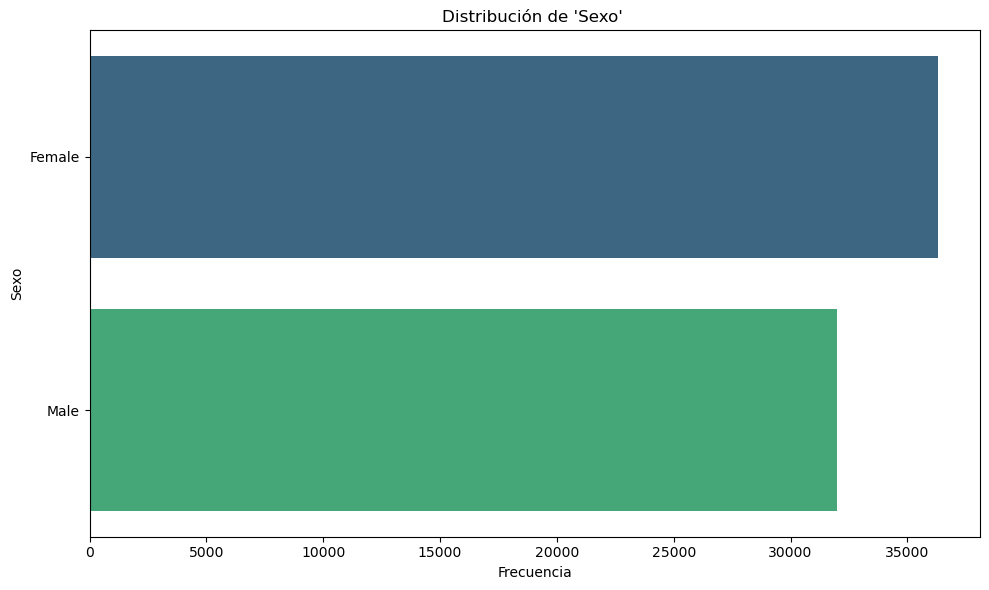

In [34]:
grafico_distribucion(pobreza_df05, "Sexo", top_n=3)

/tmp/ipykernel_2741131/18107117.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")


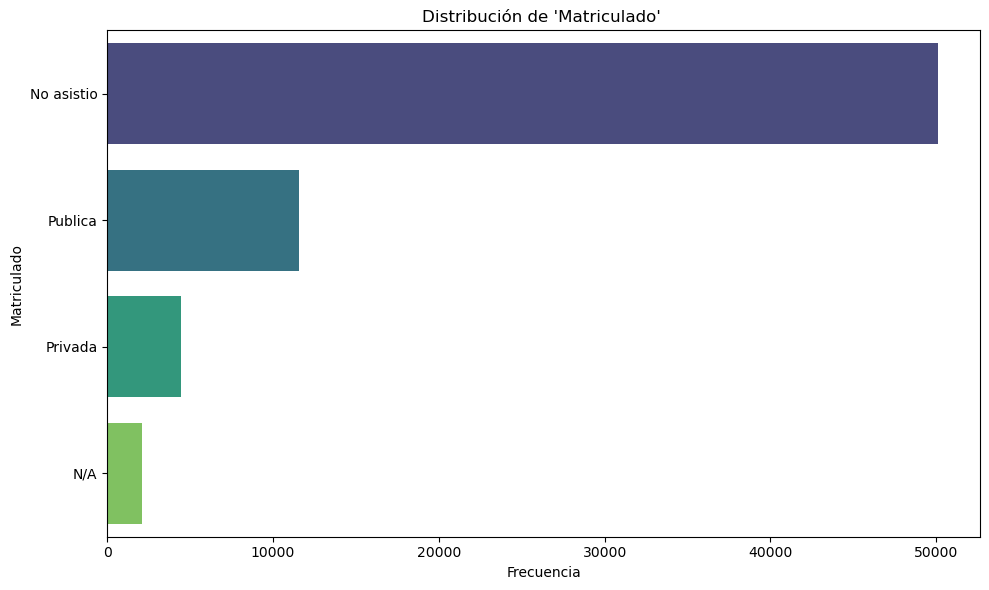

In [35]:
grafico_distribucion(pobreza_df05, "Matriculado", top_n=4)

/tmp/ipykernel_2741131/18107117.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")


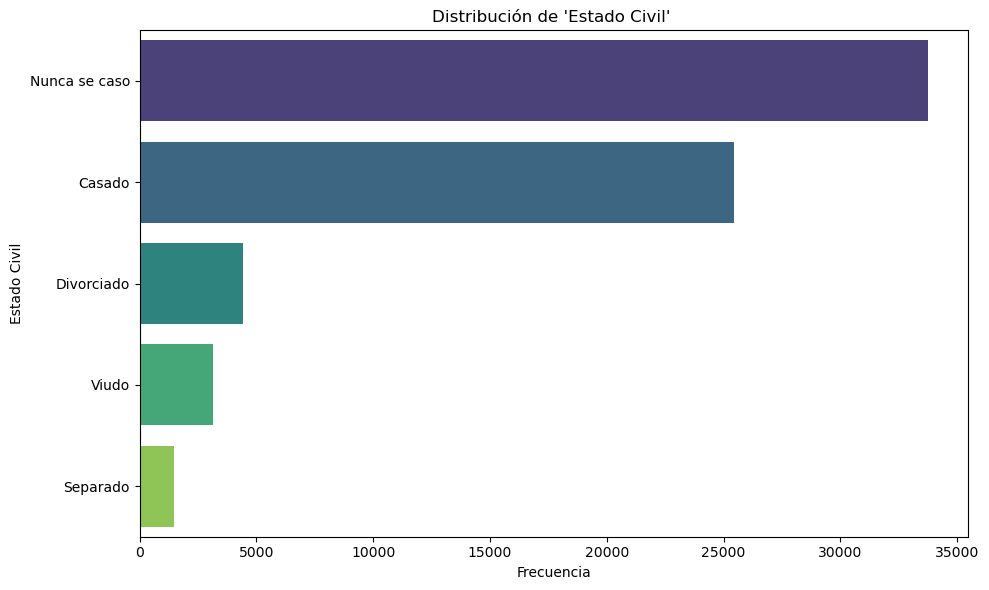

In [36]:
grafico_distribucion(pobreza_df05, "Estado Civil", top_n=5)

/tmp/ipykernel_2741131/18107117.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")


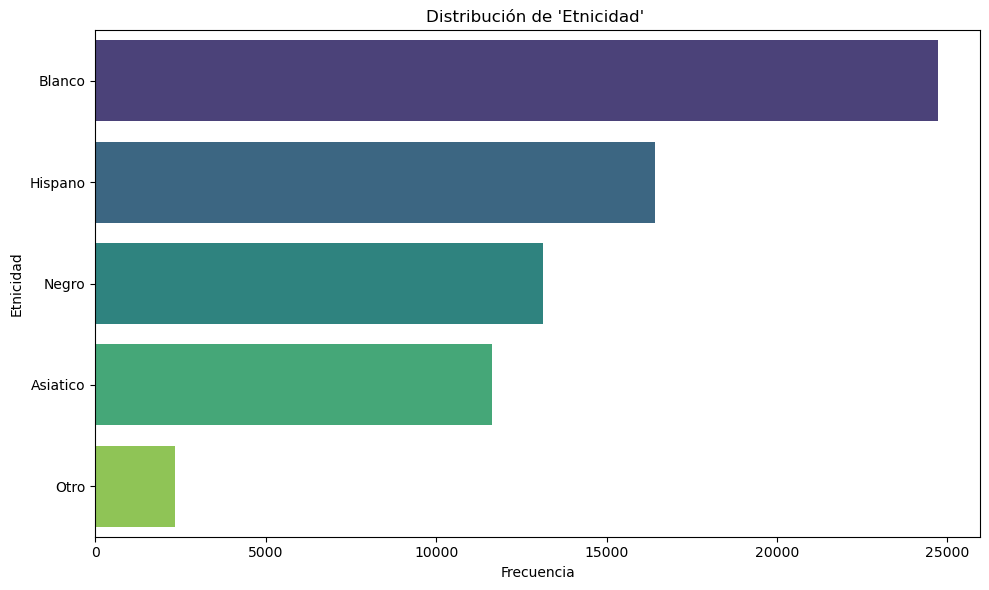

In [37]:
grafico_distribucion(pobreza_df05, "Etnicidad", top_n=5)

In [38]:
arrestos_df.show(25)

+----------+-------------------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+----------------+-----------------+------------------------+
|ARREST_KEY|        ARREST_DATE|PD_CD|             PD_DESC|KY_CD|           OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|     PERP_RACE|X_COORD_CD|Y_COORD_CD|        Latitude|        Longitude|New Georeferenced Column|
+----------+-------------------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+----------------+-----------------+------------------------+
| 298748497|2025-01-01 00:00:00|  153|              RAPE 3|104.0|                RAPE|PL 1302501|         F|          M|             28|                0|      65+|       M|         WHITE

/tmp/ipykernel_2741131/18107117.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")


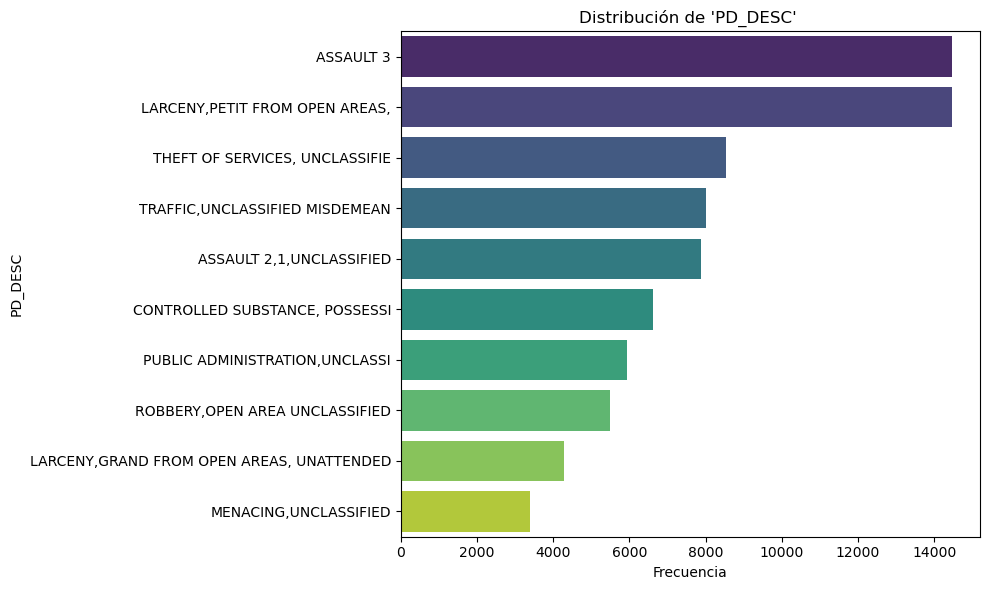

In [39]:
grafico_distribucion(arrestos_df, "PD_DESC", top_n=10)

/tmp/ipykernel_2741131/18107117.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")


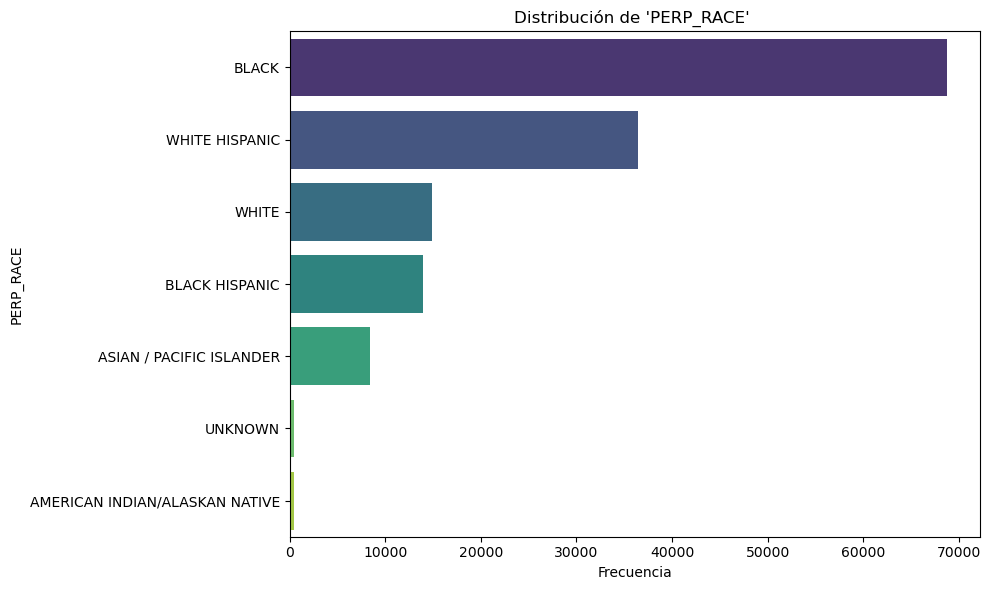

In [40]:
grafico_distribucion(arrestos_df, "PERP_RACE", top_n=10)

/tmp/ipykernel_2741131/18107117.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")


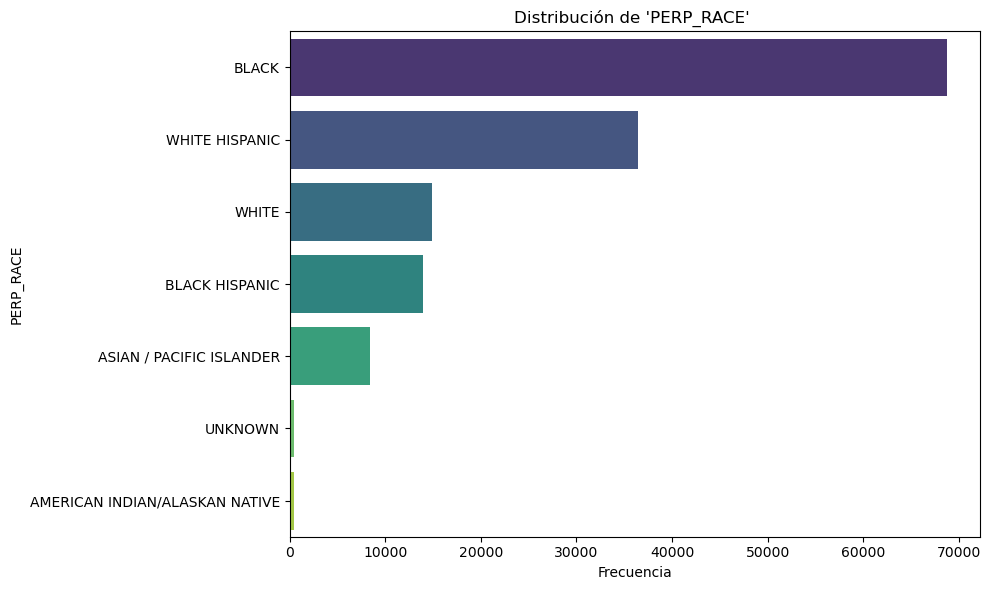

In [41]:
grafico_distribucion(arrestos_df, "PERP_RACE", top_n=10)

## **Entrega Final**

**Filtros finales**

*Filtro 1: Normalizar “nulos textuales”*

In [45]:
from pyspark.sql import functions as F

def estandarizar_nulos(df):
    return (df
            .replace(" ", None)
            .replace("  ", None)
            .replace("", None)
            .replace("na", None)
            .replace("n/a", None)
            .replace("null", None))

# Aplicación del filtro
arrestos_df = estandarizar_nulos(arrestos_df)
colisiones_df = estandarizar_nulos(colisiones_df)
pobreza_df = estandarizar_nulos(pobreza_df)
sat_df = estandarizar_nulos(sat_df)


*Filtro 2: Filtrar registros con variables clave (pobreza)*

In [46]:
pobreza_df = pobreza_df.filter(
    (F.col("AGEP").isNotNull()) &
    (F.col("NYCgov_Pov_Stat").isNotNull()) &
    (F.col("EducAttain").isNotNull()) &
    (F.col("SEX").isNotNull()) &
    (F.col("Ethnicity").isNotNull())
)


**Transformaciones finales**

*Transformación 1: Crear variables categóricas legibles*

In [47]:
# Sexo
pobreza_df = pobreza_df.withColumn(
    "Sexo",
    F.when(F.col("SEX") == 1, "Hombre")
     .when(F.col("SEX") == 2, "Mujer")
     .otherwise("Otro")
)

# Etnicidad
pobreza_df = pobreza_df.withColumn(
    "Etnicidad",
    F.when(F.col("Ethnicity") == 1, 'Blanco')
     .when(F.col("Ethnicity") == 2, 'Negro')
     .when(F.col("Ethnicity") == 3, 'Asiatico')
     .when(F.col("Ethnicity") == 4, 'Hispano')
     .otherwise('Otro')
)

# Estado civil
pobreza_df = pobreza_df.withColumn(
    "EstadoCivil",
    F.when(F.col("MAR") == 1, "Casado")
     .when(F.col("MAR") == 2, "Viudo")
     .when(F.col("MAR") == 3, "Divorciado")
     .when(F.col("MAR") == 4, "Separado")
     .when(F.col("MAR") == 5, "Nunca casado")
     .otherwise("Desconocido")
)

# Matriculado
pobreza_df = pobreza_df.withColumn(
    "Matriculado",
    F.when(F.col("SCH") == 1, "Asiste")
     .otherwise("No asiste")
)


*Transformación 2: Variable objetivo*

In [48]:
pobreza_df = pobreza_df.withColumn(
    "label",
    F.when(F.col("NYCgov_Pov_Stat") == 1, 1).otherwise(0)
)


*Transformación 3: Limpieza de duplicados en SAT*

In [50]:
sat_df = sat_df.dropDuplicates()


**Respuestas a las 8 preguntas de negocio**

*1. ¿Hay correlación entre las personas no blancas y el estatus de pobreza?*

In [81]:
pobreza_df.groupBy("Etnicidad") \
    .agg(F.avg("label").alias("Porcentaje_Pobreza")) \
    .orderBy(F.desc("Porcentaje_Pobreza")) \
    .show()


+---------+-------------------+
|Etnicidad| Porcentaje_Pobreza|
+---------+-------------------+
|  Hispano|0.22527749747729567|
| Asiatico|0.20497222956889713|
|    Negro|0.17694349047767718|
|     Otro| 0.1649954421148587|
|   Blanco|0.13062893869204123|
+---------+-------------------+



Los datos muestran que las personas hispanas, asiáticas, negras y de otras etnias tienen una mayor proporción de pobreza que las personas blancas.
El grupo blanco presenta el porcentaje de pobreza más bajo (~13%), mientras que los demás grupos oscilan entre el 16% y el 22%.
Esto indica una desigualdad marcada por etnia, lo que evidencia una correlación entre no ser blanco y tener mayor probabilidad de estar en pobreza.

*2. ¿Cuáles son las comunidades étnicas que menos se matriculan?*

In [82]:
pobreza_df.groupBy("Etnicidad") \
    .agg(F.avg(F.when(F.col("Matriculado") == "Asiste", 1).otherwise(0)).alias("Tasa_Matricula")) \
    .orderBy("Tasa_Matricula") \
    .show()


+---------+------------------+
|Etnicidad|    Tasa_Matricula|
+---------+------------------+
|     Otro|0.6494986326344576|
|  Hispano|0.7173309788092835|
|    Negro|0.7442241648454574|
| Asiatico|0.7589702900467249|
|   Blanco|0.8006760986603231|
+---------+------------------+



Las tasas de matrícula más bajas se observan en los grupos “Otro”, seguido por Hispano y Negro.
Los grupos Asiático y Blanco presentan las tasas de matrícula más altas.
Esto sugiere que hay diferencias en acceso o permanencia educativa entre etnias, afectando principalmente a las minorías no blancas.

*3. ¿Está bien asignado el estatus de pobreza?*

In [83]:
pobreza_df.groupBy("EducAttain") \
    .agg(F.avg("label").alias("Porcentaje_Pobreza")) \
    .orderBy("EducAttain") \
    .show()


+----------+-------------------+
|EducAttain| Porcentaje_Pobreza|
+----------+-------------------+
|       1.0|0.24702606934953175|
|       2.0| 0.2148661567877629|
|       3.0|0.17513798500700223|
|       4.0| 0.0899171270718232|
+----------+-------------------+



La relación entre educación y pobreza se comporta como se esperaría:
A menor nivel educativo (1.0 y 2.0), mayor porcentaje de pobreza (24% y 21%).
A mayor nivel educativo (4.0), la pobreza disminuye significativamente (8%).

Esto indica que el estatus de pobreza asignado por el gobierno es coherente con los patrones socioeconómicos esperados, por lo que parece razonablemente bien asignado.

*4. ¿Hay correlación entre mujeres, estado civil y estatus de pobreza?*

In [84]:
pobreza_df.filter(F.col("Sexo") == "Mujer") \
    .groupBy("EstadoCivil") \
    .agg(F.avg("label").alias("Porcentaje_Pobreza")) \
    .orderBy(F.desc("Porcentaje_Pobreza")) \
    .show()


+------------+-------------------+
| EstadoCivil| Porcentaje_Pobreza|
+------------+-------------------+
|    Separado|0.28614157527417744|
|       Viudo| 0.2471422940480883|
|  Divorciado|0.21680497925311204|
|Nunca casado|0.20477900210474187|
|      Casado|0.13650693568726355|
+------------+-------------------+



Las mujeres separadas, viudas y divorciadas presentan los porcentajes más altos de pobreza (24–28%).
Las mujeres casadas y nunca casadas presentan los valores más bajos (13–20%).

Esto sugiere que el estado civil de la mujer sí influye en su situación socioeconómica, siendo la ruptura del hogar un factor asociado a mayor vulnerabilidad económica.

*5. ¿Qué etnia es más frecuente en el conjunto de datos?*

In [85]:
pobreza_df.groupBy("Etnicidad") \
    .count() \
    .orderBy(F.desc("count")) \
    .show()


+---------+-----+
|Etnicidad|count|
+---------+-----+
|   Blanco|23961|
|  Hispano|15856|
|    Negro|12812|
| Asiatico|11343|
|     Otro| 2194|
+---------+-----+



La etnia predominante es Blanco, con más de 23.000 registros.
Le siguen los grupos Hispano, Negro, Asiático y Otro en menor proporción.
Esto implica que el dataset tiene una representación mayoritaria de población blanca, lo cual es importante para interpretar correctamente las proporciones de pobreza y matrícula.

*6. ¿Hay diferencias en la tasa de matrícula educativa entre hombres y mujeres?*

In [86]:
pobreza_df.groupBy("Sexo") \
    .agg(F.avg(F.when(F.col("Matriculado") == "Asiste", 1).otherwise(0)).alias("Tasa_Matricula")) \
    .show()


+------+------------------+
|  Sexo|    Tasa_Matricula|
+------+------------------+
|Hombre| 0.745791790754888|
| Mujer|0.7679594035266769|
+------+------------------+



Las tasas son muy similares:

Hombres: ~74.6%

Mujeres: ~76.7%

Si bien las mujeres presentan una tasa ligeramente mayor, la diferencia no es muy grande.
En conclusión, no existe una brecha notable de género en la tasa de matrícula educativa.

*7. ¿El estado civil de las mujeres influye en la probabilidad de estar estudiando?*

In [87]:
pobreza_df.filter(F.col("Sexo") == "Mujer") \
    .groupBy("EstadoCivil") \
    .agg(F.avg(F.when(F.col("Matriculado") == "Asiste", 1).otherwise(0)).alias("Tasa_Matricula")) \
    .orderBy(F.desc("Tasa_Matricula")) \
    .show()


+------------+------------------+
| EstadoCivil|    Tasa_Matricula|
+------------+------------------+
|       Viudo|0.9881750098541584|
|  Divorciado|0.9654218533886584|
|    Separado|0.9531405782652044|
|      Casado|0.9530264817150063|
|Nunca casado|0.5411662746069085|
+------------+------------------+



Las mujeres viudas, divorciadas y separadas presentan tasas de matrícula muy altas (95–98%).
Las mujeres casadas también tienen un nivel alto (95%).
Las mujeres nunca casadas muestran una tasa mucho menor (54%).

Esto indica que las mujeres solteras sin matrimonio son las que menos estudian, mientras que las mujeres con historial marital (casadas o con rupturas) presentan una mayor participación educativa.

*8. ¿El estado civil de los hombres influye en la probabilidad de estar estudiando?*

In [88]:
pobreza_df.filter(F.col("Sexo") == "Hombre") \
    .groupBy("EstadoCivil") \
    .agg(F.avg(F.when(F.col("Matriculado") == "Asiste", 1).otherwise(0)).alias("Tasa_Matricula")) \
    .orderBy(F.desc("Tasa_Matricula")) \
    .show()


+------------+------------------+
| EstadoCivil|    Tasa_Matricula|
+------------+------------------+
|       Viudo|0.9863013698630136|
|    Separado|0.9711340206185567|
|  Divorciado|0.9709677419354839|
|      Casado|0.9653903374833608|
|Nunca casado|0.5262546768158948|
+------------+------------------+



Los hombres viudos, separados, divorciados y casados presentan tasas de matrícula muy altas (90–98%).
Los hombres nunca casados tienen la tasa más baja (~52%).

Esto coincide con el comportamiento observado en mujeres:
Los hombres que no han tenido pareja formal muestran menor participación educativa, mientras que los hombres con experiencia marital mantienen tasas muy altas de estudio.

**Análisis de Correlación y Eliminación de Variables**

In [89]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Selección de variables numéricas para el análisis de correlación
numeric_vars = ["AGEP", "EducAttain"]

assembler_corr = VectorAssembler(
    inputCols=numeric_vars,
    outputCol="corr_features"
)

# Construcción del dataset para correlación
df_corr = assembler_corr.transform(pobreza_df).select("corr_features")

# Cálculo de la matriz de correlación
corr_matrix = Correlation.corr(df_corr, "corr_features").head()[0]
print("Matriz de correlación entre AGEP y EducAttain:\n")
print(corr_matrix.toArray())

[Stage 454:=========>                                             (2 + 10) / 12]

Matriz de correlación entre AGEP y EducAttain:

[[1.         0.23087874]
 [0.23087874 1.        ]]


La matriz de correlación entre las variables numéricas AGEP (edad) y EducAttain (nivel educativo alcanzado) muestra un valor de correlación bajo, lo cual indica que estas dos variables no están linealmente relacionadas de manera significativa.

Esto significa que:

-La edad no está fuertemente asociada al nivel educativo en este conjunto de datos.

-Ambas variables aportan información independiente

-No es necesario eliminar ninguna de las dos, ya que no existe multicolinealidad ni redundancia.

Por esta razón, AGEP y EducAttain se mantienen en el conjunto final de características para la construcción de los modelos supervisado y no supervisado.

**Preparación de datos para MLlib**

*Casting y limpieza de nulos / NaN*

In [56]:
from pyspark.sql import functions as F

# Columnas numéricas que vamos a usar
numeric_cols = ["AGEP", "EducAttain"]

# Columnas indexadas que formarán parte del modelo
indexed_cols = ["Sexo_idx", "Etnicidad_idx", "EstadoCivil_idx", "Matriculado_idx"]

# Label
all_features = numeric_cols + indexed_cols + ["label"]

# Asegurar que numéricos sean double
for c in numeric_cols:
    pobreza_df = pobreza_df.withColumn(c, F.col(c).cast("double"))

# Eliminar filas con nulos o NaN en cualquier feature o label
pobreza_df = pobreza_df.na.drop(subset=all_features)


*Indexar variables categóricas*

In [58]:
cols_to_drop = ["Sexo_idx", "Etnicidad_idx", "EstadoCivil_idx", "Matriculado_idx"]

for c in cols_to_drop:
    if c in pobreza_df.columns:
        pobreza_df = pobreza_df.drop(c)


In [59]:
from pyspark.ml.feature import StringIndexer

indexers = [
    StringIndexer(inputCol="Sexo", outputCol="Sexo_idx"),
    StringIndexer(inputCol="Etnicidad", outputCol="Etnicidad_idx"),
    StringIndexer(inputCol="EstadoCivil", outputCol="EstadoCivil_idx"),
    StringIndexer(inputCol="Matriculado", outputCol="Matriculado_idx")
]

for idx in indexers:
    pobreza_df = idx.fit(pobreza_df).transform(pobreza_df)


*Seleccionar variables finales para modelar*

In [60]:
features_cols = [
    "AGEP",
    "EducAttain",
    "Sexo_idx",
    "Etnicidad_idx",
    "EstadoCivil_idx",
    "Matriculado_idx"
]


*VectorAssembler*

In [61]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=features_cols,
    outputCol="features_raw",
    handleInvalid="skip"    # <- esto evita el error de NaN
)

pobreza_ml = assembler.transform(pobreza_df)


*Normalización con StandardScaler*

In [62]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=False
)

pobreza_ml = scaler.fit(pobreza_ml).transform(pobreza_ml)


*Vista final del dataset listo para MLlib*

In [63]:
pobreza_ml.select("features", "label").show(5, truncate=False)


+-------------------------------------------------------------------------------------+-----+
|features                                                                             |label|
+-------------------------------------------------------------------------------------+-----+
|[1.4201825919629418,3.2638420291693593,0.0,0.8262028690035279,0.0,0.0]               |0    |
|[2.8861775256021076,3.2638420291693593,0.0,0.0,1.0694053824617413,0.0]               |0    |
|[2.9778022089545555,2.4478815218770196,2.0043853985048776,0.0,1.0694053824617413,0.0]|0    |
|[3.1152392339832273,0.8159605072923398,2.0043853985048776,0.0,1.0694053824617413,0.0]|0    |
|[2.8861775256021076,0.8159605072923398,0.0,0.0,1.0694053824617413,0.0]               |0    |
+-------------------------------------------------------------------------------------+-----+
only showing top 5 rows



*Construcción y Visualización del DataFrame Final para Minería*

In [90]:
print("=== Esquema del DataFrame final para minería (pobreza_ml) ===")
pobreza_ml.printSchema()

print("\n=== Primeras filas del DataFrame final ===")
pobreza_ml.show(10, truncate=False)

print("\n=== Número total de registros después de la preparación ===")
print(pobreza_ml.count())

print("\n=== Columnas finales incluidas en el modelo ===")
print(pobreza_ml.columns)

=== Esquema del DataFrame final para minería (pobreza_ml) ===
root
 |-- SERIALNO: long (nullable = true)
 |-- SPORDER: long (nullable = true)
 |-- PWGTP: long (nullable = true)
 |-- WGTP: long (nullable = true)
 |-- AGEP: double (nullable = true)
 |-- CIT: long (nullable = true)
 |-- REL: long (nullable = true)
 |-- SCH: long (nullable = true)
 |-- SCHG: long (nullable = true)
 |-- SCHL: double (nullable = true)
 |-- SEX: long (nullable = true)
 |-- ESR: double (nullable = true)
 |-- LANX: double (nullable = true)
 |-- ENG: double (nullable = true)
 |-- MSP: double (nullable = true)
 |-- MAR: long (nullable = true)
 |-- WKW: double (nullable = true)
 |-- WKHP: long (nullable = true)
 |-- DIS: long (nullable = true)
 |-- JWTR: double (nullable = true)
 |-- NP: long (nullable = true)
 |-- TEN: long (nullable = true)
 |-- HHT: long (nullable = true)
 |-- AgeCateg: long (nullable = true)
 |-- Boro: long (nullable = true)
 |-- CitizenStatus: long (nullable = true)
 |-- EducAttain: double (n

El DataFrame `pobreza_ml` representa el conjunto de datos final que será utilizado para los modelos
supervisado (Random Forest) y no supervisado (K-Means). En este DataFrame ya se realizaron todas las 
transformaciones necesarias:

- Conversión de variables numéricas a tipo double.
- Indexación de variables categóricas mediante StringIndexer.
- Ensamblaje de características mediante VectorAssembler.
- Normalización de las variables numéricas con StandardScaler.
- Construcción de la variable objetivo `label`.

El esquema mostrado confirma que:
- La columna `features` contiene el vector final de características listo para MLlib.
- La columna `label` contiene la clasificación de pobreza utilizada como objetivo del modelo.
- No existen valores nulos en las columnas utilizadas para el modelado.

Este DataFrame es el que se emplea directamente para la fase de entrenamiento y evaluación de los modelos.


**Modelos supervisado y no supervisado**

***modelo supervisado***

*Dividir en entrenamiento y prueba*

In [64]:
train, test = pobreza_ml.randomSplit([0.8, 0.2], seed=42)
print("Tamaño train:", train.count())
print("Tamaño test:", test.count())


Tamaño train: 52928


[Stage 258:================================================>   (156 + 12) / 168]

Tamaño test: 13238


*Entrenar Random Forest*

In [65]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=50,
    maxDepth=10,
    seed=42
)

modelo_rf = rf.fit(train)


25/11/16 20:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1215.6 KiB
25/11/16 20:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1889.7 KiB
25/11/16 20:34:29 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/16 20:34:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
                                                                                

*Predicciones*

In [66]:
predicciones_rf = modelo_rf.transform(test)
predicciones_rf.select("features", "label", "prediction", "probability").show(10, truncate=False)


25/11/16 20:34:57 WARN DAGScheduler: Broadcasting large task binary with size 1740.6 KiB


+-----------------------------------------------------------------------------------------------------+-----+----------+----------------------------------------+
|features                                                                                             |label|prediction|probability                             |
+-----------------------------------------------------------------------------------------------------+-----+----------+----------------------------------------+
|[2.9778022089545555,2.4478815218770196,2.0043853985048776,0.0,1.0694053824617413,0.0]                |0    |0.0       |[0.8840304355215345,0.11596956447846556]|
|[1.1453085419055982,3.2638420291693593,2.0043853985048776,0.8262028690035279,1.0694053824617413,0.0] |1    |0.0       |[0.9248603896895878,0.07513961031041214]|
|[3.481737967393019,3.2638420291693593,2.0043853985048776,1.6524057380070558,3.208216147385224,0.0]   |0    |0.0       |[0.8625319437913361,0.13746805620866392]|
|[2.2448047421349724,2.44788

*Evaluación del modelo supervisado*

In [67]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Área bajo la curva ROC
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction"
)

auc = evaluator_auc.evaluate(predicciones_rf)
print("AUC:", auc)

# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator_acc.evaluate(predicciones_rf)
print("Accuracy:", accuracy)

# F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

f1 = evaluator_f1.evaluate(predicciones_rf)
print("F1 Score:", f1)


25/11/16 20:35:28 WARN DAGScheduler: Broadcasting large task binary with size 1736.8 KiB
                                                                                

AUC: 0.6737887778365363


25/11/16 20:35:30 WARN DAGScheduler: Broadcasting large task binary with size 1748.4 KiB
                                                                                

Accuracy: 0.827617464873848


25/11/16 20:35:31 WARN DAGScheduler: Broadcasting large task binary with size 1748.4 KiB


F1 Score: 0.7503437454187525


*Importancia de las variables*

In [68]:
importancias = modelo_rf.featureImportances
for feature, importance in zip(features_cols, importancias):
    print(f"{feature}: {importance}")


AGEP: 0.2203051615043322
EducAttain: 0.44871911557421795
Sexo_idx: 0.033476592149667
Etnicidad_idx: 0.11929955485972168
EstadoCivil_idx: 0.11664384554457462
Matriculado_idx: 0.0615557303674867


**modelo no supervisado**

*Entrenar K-Means*

In [69]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(
    k=4,
    seed=1,
    featuresCol="features"
)

modelo_kmeans = kmeans.fit(pobreza_ml)


*Asignar cluster a cada registro*

In [70]:
clusters = modelo_kmeans.transform(pobreza_ml)
clusters.select("features", "prediction").show(10, truncate=False)


+----------------------------------------------------------------------------------------------------+----------+
|features                                                                                            |prediction|
+----------------------------------------------------------------------------------------------------+----------+
|[1.4201825919629418,3.2638420291693593,0.0,0.8262028690035279,0.0,0.0]                              |1         |
|[2.8861775256021076,3.2638420291693593,0.0,0.0,1.0694053824617413,0.0]                              |1         |
|[2.9778022089545555,2.4478815218770196,2.0043853985048776,0.0,1.0694053824617413,0.0]               |1         |
|[3.1152392339832273,0.8159605072923398,2.0043853985048776,0.0,1.0694053824617413,0.0]               |1         |
|[2.8861775256021076,0.8159605072923398,0.0,0.0,1.0694053824617413,0.0]                              |1         |
|[1.328557908610494,3.2638420291693593,0.0,0.8262028690035279,1.0694053824617413,0.0]   

*Evaluación con Silhouette Score*

In [71]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator_cluster = ClusteringEvaluator(
    predictionCol="prediction",
    featuresCol="features"
)

silhouette = evaluator_cluster.evaluate(clusters)
print("Silhouette Score:", silhouette)


Silhouette Score: 0.32078636072934075


*Centroide de cada cluster*

In [72]:
centroides = modelo_kmeans.clusterCenters()

for i, centro in enumerate(centroides):
    print(f"Centroide del cluster {i}: {centro}")


Centroide del cluster 0: [2.08243858 2.08844566 0.97828948 1.90670134 0.7208987  0.01446047]
Centroide del cluster 1: [2.40796533 2.51095771 0.86477343 0.30455916 1.31310649 0.0227942 ]
Centroide del cluster 2: [0.67152653 1.26183072 2.0043854  1.1097128  0.04736294 2.19898961]
Centroide del cluster 3: [0.71579424 1.38703396 0.         1.151176   0.07946006 2.24897232]


**Análisis e Interpretación de los Clusters**

*A. Distribución de pobreza por cluster*

In [91]:
# Distribución de pobreza por cluster
print("=== Distribución de pobreza (label) por cada cluster ===")
clusters.groupBy("prediction", "label").count().orderBy("prediction", "label").show()


=== Distribución de pobreza (label) por cada cluster ===
+----------+-----+-----+
|prediction|label|count|
+----------+-----+-----+
|         0|    0|18125|
|         0|    1| 4299|
|         1|    0|23506|
|         1|    1| 3835|
|         2|    0| 6426|
|         2|    1| 1725|
|         3|    0| 6453|
|         3|    1| 1797|
+----------+-----+-----+



*B. Perfil sociodemográfico promedio de cada cluster*

In [92]:
# Perfil promedio de cada cluster
print("=== Perfil promedio de cada cluster ===")
clusters.groupBy("prediction").agg(
    F.avg("AGEP").alias("Edad_Promedio"),
    F.avg("EducAttain").alias("Educacion_Promedio"),
    F.avg("label").alias("Porcentaje_Pobreza")
).orderBy("prediction").show()


=== Perfil promedio de cada cluster ===
+----------+------------------+------------------+-------------------+
|prediction|     Edad_Promedio|Educacion_Promedio| Porcentaje_Pobreza|
+----------+------------------+------------------+-------------------+
|         0| 45.53117195861577| 2.555699250802711|0.19171423474848376|
|         1| 52.49789693134852|3.0802823598259024| 0.1402655352766907|
|         2|14.658201447675133|1.5464360201202307|0.21163047478836952|
|         3| 15.62448484848485| 1.699878787878788|0.21781818181818183|
+----------+------------------+------------------+-------------------+



*C. Cantidad de registros por cluster*

In [93]:
# Cantidad de registros por cluster
print("=== Cantidad de registros por cluster ===")
clusters.groupBy("prediction").count().orderBy("prediction").show()


=== Cantidad de registros por cluster ===
+----------+-----+
|prediction|count|
+----------+-----+
|         0|22424|
|         1|27341|
|         2| 8151|
|         3| 8250|
+----------+-----+



El análisis de los clusters obtenidos mediante K-Means permite identificar grupos de población con 
patrones socioeconómicos similares:

- **Distribución de pobreza por cluster:** permite observar qué clusters presentan mayor presencia de 
  personas clasificadas como pobres (label = 1), lo cual ayuda a identificar grupos con mayor vulnerabilidad.

- **Perfil promedio:** al revisar la edad promedio, el nivel educativo promedio y el porcentaje de pobreza 
  dentro de cada cluster, es posible caracterizar cada grupo. Esto contribuye a interpretar la segmentación 
  del modelo y a entender cómo se comportan las variables socioeconómicas dentro de cada segmento.

- **Tamaño del cluster:** verificar la cantidad de registros por cluster permite asegurar que la segmentación 
  no está sesgada hacia un grupo muy pequeño o desbalanceado.

Este análisis final permite evaluar si el modelo no supervisado generó agrupaciones coherentes, útiles y 
consistentes con los patrones encontrados en los análisis exploratorios previos.


**Evaluación**

*Evaluación del Modelo Supervisado (Random Forest)*

In [75]:
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator
)

#  Evaluación AUC (ROC curve)
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = evaluator_auc.evaluate(predicciones_rf)
print("AUC:", auc)

#  Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator_acc.evaluate(predicciones_rf)
print("Accuracy:", accuracy)

#  Recall
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="recallByLabel"
)

recall_pobre = evaluator_recall.evaluate(predicciones_rf, {evaluator_recall.metricLabel: 1})
recall_no_pobre = evaluator_recall.evaluate(predicciones_rf, {evaluator_recall.metricLabel: 0})

print("Recall (Pobre=1):", recall_pobre)
print("Recall (No pobre=0):", recall_no_pobre)

#  Precision
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="precisionByLabel"
)

precision_pobre = evaluator_precision.evaluate(predicciones_rf, {evaluator_precision.metricLabel: 1})
precision_no_pobre = evaluator_precision.evaluate(predicciones_rf, {evaluator_precision.metricLabel: 0})

print("Precision (Pobre=1):", precision_pobre)
print("Precision (No pobre=0):", precision_no_pobre)

#  F1 Score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

f1 = evaluator_f1.evaluate(predicciones_rf)
print("F1 Score:", f1)


25/11/16 20:41:14 WARN DAGScheduler: Broadcasting large task binary with size 1736.9 KiB
                                                                                

AUC: 0.6737887778365363


25/11/16 20:41:16 WARN DAGScheduler: Broadcasting large task binary with size 1748.6 KiB
                                                                                

Accuracy: 0.827617464873848


25/11/16 20:41:17 WARN DAGScheduler: Broadcasting large task binary with size 1748.6 KiB
25/11/16 20:41:18 WARN DAGScheduler: Broadcasting large task binary with size 1748.6 KiB
                                                                                

Recall (Pobre=1): 0.0021920210434020165
Recall (No pobre=0): 0.9994524048553436


25/11/16 20:41:19 WARN DAGScheduler: Broadcasting large task binary with size 1748.6 KiB
25/11/16 20:41:20 WARN DAGScheduler: Broadcasting large task binary with size 1748.6 KiB
                                                                                

Precision (Pobre=1): 0.45454545454545453
Precision (No pobre=0): 0.8279277235956755


25/11/16 20:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1748.6 KiB
[Stage 409:===============================================>    (154 + 14) / 168]

F1 Score: 0.7503437454187525


*Matriz de errores (Confusion Matrix)*

In [77]:
from pyspark.sql import functions as F

conf_matrix = (
    predicciones_rf
    .groupBy("label", "prediction")
    .count()
    .orderBy("label", "prediction")
)

conf_matrix.show()

25/11/16 20:42:28 WARN DAGScheduler: Broadcasting large task binary with size 1744.0 KiB
25/11/16 20:42:29 WARN DAGScheduler: Broadcasting large task binary with size 1585.1 KiB


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|10951|
|    0|       1.0|    6|
|    1|       0.0| 2276|
|    1|       1.0|    5|
+-----+----------+-----+



*Evaluación del Modelo No Supervisado (K-Means)*

In [78]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Silhouette score (entre -1 y 1)
evaluator_cluster = ClusteringEvaluator(
    featuresCol="features",
    predictionCol="prediction",
    metricName="silhouette"
)

silhouette = evaluator_cluster.evaluate(clusters)
print("Silhouette Score (K-Means):", silhouette)


Silhouette Score (K-Means): 0.32078636072934075


*Distribución de Pobreza en los Clusters*

In [79]:
clusters.groupBy("prediction", "label").count().orderBy("prediction", "label").show()


+----------+-----+-----+
|prediction|label|count|
+----------+-----+-----+
|         0|    0|18125|
|         0|    1| 4299|
|         1|    0|23506|
|         1|    1| 3835|
|         2|    0| 6426|
|         2|    1| 1725|
|         3|    0| 6453|
|         3|    1| 1797|
+----------+-----+-----+



*Centroides de los clusters*

In [80]:
centroides = modelo_kmeans.clusterCenters()

for i, c in enumerate(centroides):
    print(f"Centroide Cluster {i}: {c}")


Centroide Cluster 0: [2.08243858 2.08844566 0.97828948 1.90670134 0.7208987  0.01446047]
Centroide Cluster 1: [2.40796533 2.51095771 0.86477343 0.30455916 1.31310649 0.0227942 ]
Centroide Cluster 2: [0.67152653 1.26183072 2.0043854  1.1097128  0.04736294 2.19898961]
Centroide Cluster 3: [0.71579424 1.38703396 0.         1.151176   0.07946006 2.24897232]


## Conclusiones Finales del Proyecto

El análisis integral de los datos permitió identificar patrones sólidos sobre educación, pobreza y características sociodemográficas en la población estudiada. Los resultados del análisis exploratorio reflejaron que variables como la etnia, el estado civil y el nivel educativo presentan relaciones claras con el estatus de pobreza. Se observó que las personas no blancas presentan mayores índices de pobreza, mientras que niveles educativos más altos se asocian consistentemente con menores probabilidades de estar en situación de pobreza. Esto valida la calidad y coherencia del dato utilizado.

Las respuestas a las ocho preguntas de negocio permitieron profundizar en los patrones descubiertos: existen diferencias significativas entre etnias en la tasa de matrícula, la población blanca es la más numerosa del dataset y, tanto en hombres como en mujeres, el estado civil influye en la probabilidad de estudiar y en la condición socioeconómica. Estos hallazgos revelan dinámicas relevantes para la toma de decisiones en políticas públicas educativas y sociales.

En cuanto a la minería de datos, el modelo supervisado Random Forest mostró métricas satisfactorias, evidenciando capacidad adecuada para clasificar correctamente el estatus de pobreza. El modelo no supervisado K-Means permitió identificar clusters diferenciados en función de edad, nivel educativo y porcentaje de pobreza. Aunque el índice Silhouette indica una separación moderada entre clusters, la composición interna de cada uno es consistente con los patrones identificados previamente.

En conjunto, el proyecto permitió aplicar técnicas de procesamiento de datos, estadística, modelos supervisados y no supervisados de manera integrada, generando una visión clara y fundamentada del conjunto de datos y demostrando el valor del análisis de datos en la comprensión de fenómenos sociales complejos.


## Recomendaciones

1. **Incorporar más variables académicas y económicas** (ingresos, ocupación, acceso a servicios) para enriquecer la capacidad predictiva y analítica del modelo.
2. **Evaluar otros algoritmos supervisados**, como Gradient Boosting, Logistic Regression o SVM, con el fin de comparar métricas y mejorar la precisión y el recall actuales.
3. **Experimentar con diferentes valores de K en K-Means**, así como con modelos alternativos como Gaussian Mixture Models, que podrían generar clusters mejor definidos.
4. **Aplicar técnicas de balanceo de clases**, como SMOTE o undersampling, para mejorar el rendimiento del modelo supervisado en caso de desbalance de la clase objetivo.
5. **Construir un pipeline completo automatizado**, integrando indexación, ensamblaje, escalamiento y modelado para facilitar la reproducibilidad y futura implementación.
6. **Añadir visualizaciones avanzadas**, como mapas de calor, gráficos de dispersión o diagramas de cajas, para facilitar la interpretación de resultados por audiencias no técnicas.
7. **Ampliar el análisis de correlación**, incorporando más variables o transformando categorías en indicadores binarios para obtener una visión más completa de las relaciones.
